In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import random
import string
import os

from src.dataset.mydataset import LicensePlatesDataset
from src.models.model import GModel
from src.utils.attn_converter import AttnConverter
from src.loss.cross_entropy_loss import CrossEntropyLoss
from src.train.early_stopping import EarlyStopping
from src.train.trainer import train
from src.utils.postprocess import postprocess

TRAIN = False
device = 'cpu'

# Define directories
data_dir = './data'
weights_dir = './weights'


#### **Dataset**

Datasets size: train 4257, valid 1047, test 780


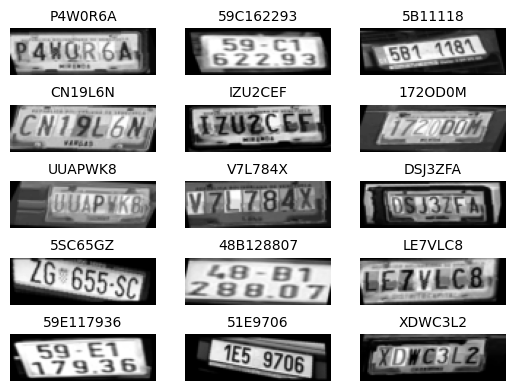

In [2]:
# Define directories and parametrs
dataset_dir = os.path.join(data_dir, 'license_plates_datasets/')
csv_file = os.path.join(data_dir, 'license_plates_datasets/dataset_merged.csv')
batch_size = 64
max_len = 10

# Define transformation
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),      # Bright, contr, ...
    transforms.Grayscale(num_output_channels=1),                                        # ToGray
    transforms.RandomRotation(degrees=10),                                              # Rand. rot.
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),                          # Rand. pers.
    transforms.Resize((32, 100)),                                                       # Resize
    transforms.ToTensor(),                                                              # ToTensor
    transforms.Normalize(mean=0.5, std=0.5),                                            # Normalize
])

# Build datasets
train_dataset = LicensePlatesDataset(root_dir=dataset_dir, csv_file=csv_file, max_len=max_len, split='train', transform=transform)
test_dataset = LicensePlatesDataset(root_dir=dataset_dir, csv_file=csv_file, max_len=max_len, split='test', transform=transform)
valid_dataset = LicensePlatesDataset(root_dir=dataset_dir, csv_file=csv_file, max_len=max_len, split='valid', transform=transform)

# Build dataloadters
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define set of datasets
datasets = [train_dataset, test_dataset, valid_dataset]

# Print len
print(f"Datasets size: train {len(train_dataset)}, valid {len(valid_dataset)}, test {len(test_dataset)}")


# Define plot
fig, axes = plt.subplots(5, 3)

# Plot random samples
for i in range(5):
    for j in range(len(datasets)):
        # Define random index
        r_idx = random.randint(0, len(datasets[j])-1)
        # Extract data from dataset
        image, label, label_len = datasets[j][r_idx][0], datasets[j][r_idx][1], datasets[j][r_idx][2]
        # Plot image
        axes[i, j].imshow(image.numpy().transpose(1,2,0), cmap='gray')
        axes[i, j].set_title(label, fontsize=10)
        axes[i, j].axis('off')

plt.show()

#### **Model**

In [10]:
# Define args
args = {
    'need_text': True, 
    'body': {
        'type': 'GBody', 
        'pipelines': [
            {'type': 'RectificatorComponent', 'from_layer': 'input', 'to_layer': 'rect', 
                'arch': {'type': 'TPS_STN', 'F': 20, 'input_size': (32, 100), 'output_size': (32, 100), 'stn': {'feature_extractor': {'encoder': { 'backbone': {'type': 'GVGG', 'layers': [('conv', {'type': 'ConvModule', 'in_channels': 1, 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': 2}), ('conv', {'type': 'ConvModule', 'in_channels': 64, 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': 2}), ('conv', {'type': 'ConvModule', 'in_channels': 128, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': 2}), ('conv', {'type': 'ConvModule', 'in_channels': 256, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}})]}}, 'collect': {'type': 'CollectBlock', 'from_layer': 'c3'}}, 'pool': {'type': 'AdaptiveAvgPool2d', 'output_size': 1}, 'head': [{'type': 'FCModule', 'in_channels': 512, 'out_channels': 256, 'activation': 'relu'}, {'type': 'FCModule', 'in_channels': 256, 'out_channels': 40, 'activation': None}]}}}, 
            {'type': 'FeatureExtractorComponent', 'from_layer': 'rect', 'to_layer': 'cnn_feat', 
                'arch': {'encoder': {'backbone': {'type': 'GResNet', 'layers': [('conv', {'type': 'ConvModule', 'in_channels': 1, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('conv', {'type': 'ConvModule', 'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': 2, 'padding': 0}), ('block', {'block_name': 'BasicBlock', 'planes': 128, 'blocks': 1, 'stride': 1}), ('conv', {'type': 'ConvModule', 'in_channels': 128, 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': 2, 'padding': 0}), ('block', {'block_name': 'BasicBlock', 'planes': 256, 'blocks': 2, 'stride': 1}), ('conv', {'type': 'ConvModule', 'in_channels': 256, 'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('pool', {'type': 'MaxPool2d', 'kernel_size': 2, 'stride': (2, 1), 'padding': (0, 1)}), ('block', {'block_name': 'BasicBlock', 'planes': 512, 'blocks': 5, 'stride': 1}), ('conv', {'type': 'ConvModule', 'in_channels': 512, 'out_channels': 512, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'norm_cfg': {'type': 'BN'}}), ('block', {'block_name': 'BasicBlock', 'planes': 512, 'blocks': 3, 'stride': 1}), ('conv', {'type': 'ConvModule', 'in_channels': 512, 'out_channels': 512, 'kernel_size': 2, 'stride': (2, 1), 'padding': (0, 1), 'norm_cfg': {'type': 'BN'}}), ('conv', {'type': 'ConvModule', 'in_channels': 512, 'out_channels': 512, 'kernel_size': 2, 'stride': 1, 'padding': 0, 'norm_cfg': {'type': 'BN'}})]}}, 'collect': {'type': 'CollectBlock', 'from_layer': 'c4'}}}, 
            {'type': 'SequenceEncoderComponent', 'from_layer': 'cnn_feat', 'to_layer': 'rnn_feat', 
                'arch': {'type': 'RNN', 'input_pool': {'type': 'AdaptiveAvgPool2d', 'output_size': (1, None)}, 'layers': [('rnn', {'type': 'LSTM', 'input_size': 512, 'hidden_size': 256, 'bidirectional': True, 'batch_first': True}), ('fc', {'type': 'Linear', 'in_features': 512, 'out_features': 256}), ('rnn', {'type': 'LSTM', 'input_size': 256, 'hidden_size': 256, 'bidirectional': True, 'batch_first': True}), ('fc', {'type': 'Linear', 'in_features': 512, 'out_features': 256})]}}
        ],
        'collect': None
    }, 
    'head': {
        'type': 'AttHead', 
        'num_class': 38, 
        'num_steps': 26, 
        'cell': {'type': 'LSTMCell', 'input_size': 294, 'hidden_size': 256}, 
        'input_attention_block': {'type': 'CellAttentionBlock', 'feat': {'from_layer': 'rnn_feat', 'type': 'ConvModule', 'in_channels': 256, 'out_channels': 256, 'kernel_size': 1, 'bias': False, 'activation': None}, 'hidden': {'type': 'ConvModule', 'in_channels': 256, 'out_channels': 256, 'kernel_size': 1, 'activation': None}, 'fusion_method': 'add', 'post': {'type': 'ConvModule', 'in_channels': 256, 'out_channels': 1, 'kernel_size': 1, 'bias': False, 'activation': 'tanh', 'order': ('act', 'conv', 'norm')}, 'post_activation': 'softmax'}, 
        'output_attention_block': None,
        'text_transform': None,
        'holistic_input_from': None,
        'generator': {'type': 'Linear', 'in_features': 256, 'out_features': 38}
    }
}

# Define model
model = GModel(body=args['body'], head=args['head'], need_text=args['need_text'])
# Move model to gpt
model.to(device)
# Load weights
model.load_state_dict(torch.load(os.path.join(weights_dir, 'tps_resnet_bilstm_attn.pth'), map_location=device)['state_dict'])

<All keys matched successfully>

#### **Training**

In [4]:
# Define params
num_epochs = 60

# Define optimizer
optimizer = optim.Adadelta(model.parameters(), lr=1, rho=0.95, eps=1e-08)
# Define converter
converter = AttnConverter(character=string.ascii_uppercase+string.digits, batch_max_length=25)
# Define criterion
criterion = CrossEntropyLoss(ignore_index=0)
# Define early stopping
early_stop = EarlyStopping(model=model, eps=1e-5, threshold=5, savePath=os.path.join(weights_dir, f"backup{num_epochs}ep.pth.tar"))

# Train model
if TRAIN:
    res = train(model=model, optimizer=optimizer, converter=converter, criterion=criterion, es=early_stop, train_loader=train_loader, valid_loader=valid_loader, num_epochs=num_epochs, device=device)
    torch.save(model.state_dict(), os.path.join(weights_dir, f"trained{num_epochs}epochs.pth.tar"))

#### **Testing**

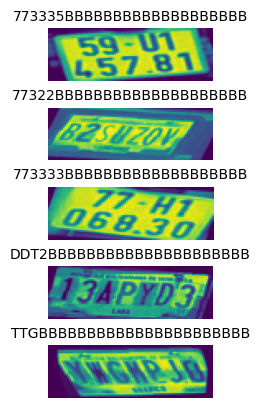

In [9]:
# Define the model
checkpoint = torch.load(os.path.join(weights_dir, f'backup{num_epochs}ep.pth.tar'), map_location=device)
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

# Define plot
fig, axes = plt.subplots(5, 1)

# For 5 times
for i in range(5):
    # Define random index
    r_idx = random.randint(0, len(test_dataset))
    # Extract r_idx-th element of the dataset
    image, label , label_len = test_dataset[r_idx][0], test_dataset[r_idx][1], test_dataset[r_idx][2]
    # Convert
    label_input, label_len, label_target = converter.test_encode([label])
    # Move to device
    image, label_input, label_target = image.to(device), label_input.to(device), label_target.to(device)
    # Predict
    pred = model((image.unsqueeze(0), label_input))
    # Convert
    pred, prob = postprocess(pred, converter, None)
    # Plot image
    axes[i].imshow(image.cpu().numpy().transpose(1,2,0))
    axes[i].set_title(f'{pred[0]}', fontsize=10)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase or decrease wspace and hspace as needed
plt.show()

In [ ]:
from src.train.trainer import compute_accuracy
# Define the model
checkpoint = torch.load(os.path.join(weights_dir, f'backup{num_epochs}ep.pth.tar'), map_location=device)
model.load_state_dict(checkpoint)

print(compute_accuracy(model, test_loader, criterion, converter, device))

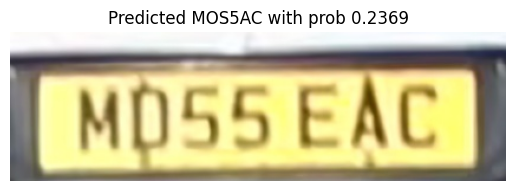

In [ ]:
import os
import pandas as pd

# Define image path
img_path = os.path.join(data_dir, 'license_plates_datasets/my_license_plates/data/2.jpg')

# Set model to evaluation mode
model.eval()
# Open image, transform it, and add batch dimension
image = transform(Image.open(img_path)).unsqueeze(0)
# Compute prediction
pred = model((image.to(device), torch.tensor([[0]]).to(device)))
# Convert prediction to str
pred, prob = postprocess(pred, converter, None)
# Plot result
plt.imshow(Image.open(img_path))
plt.title(f'Predicted {pred[0]} with prob {prob[0].item():.4f}')
plt.axis('off')
plt.show()